In [10]:
import sys
sys.path.append('/home/jovyan/work')

In [11]:
from src.data_loader import cargar_dataset, tokenize_sentences_by_char, cargar_oraciones_limpias
from collections import Counter
import re
import matplotlib.pyplot as plt

#### **CARGA DE DATOS**

In [12]:
# Cargamos 5 oraciones limpias del dataset WikiText-103
sentences = cargar_oraciones_limpias(split="train", num_oraciones=5)

# Aplicamos tokenización por caracteres
tokenized_sentences_by_char = tokenize_sentences_by_char(sentences)

# Clonamos para aplicar BPE 
bpe_sentences = [sentence[:] for sentence in tokenized_sentences_by_char]

#### **FUNCIONES AUXILIARES PARA BPE**

In [13]:
# Cuenta todos los pares de tokens adyacentes en las oraciones
def obtener_pares(sentences):
    pairs = Counter()
    for sentence in sentences:
        for i in range(len(sentence) - 1):
            pairs[(sentence[i], sentence[i+1])] += 1
    return pairs

# Realiza el merge de un par de tokens en las oraciones
def merge_pairs(sentences, pair_to_merge):
    new_sentences = []
    for sentence in sentences:
        new_sentence = []
        i = 0
        while i < len(sentence):
            if i < len(sentence) - 1 and (sentence[i], sentence[i+1]) == pair_to_merge:
                new_sentence.append(sentence[i] + sentence[i+1])
                i += 2
            else:
                new_sentence.append(sentence[i])
                i += 1
        new_sentences.append(new_sentence)
    return new_sentences

#### **ENTRENAMIENTO BÁSICO DE BPE**

In [14]:
# Número de merges que queremos aplicar
num_merges = 10

# Lista para guardar el tamaño del vocabulario después de cada merge
vocab_sizes = []

for i in range(num_merges):
    # Contamos los pares
    pairs = obtener_pares(bpe_sentences)
    
    if not pairs:
        break  # Si ya no hay pares, terminamos
    
    # Seleccionamos el par más frecuente
    best_pair = pairs.most_common(1)[0][0]
    
    # Realizamos el merge
    bpe_sentences = merge_pairs(bpe_sentences, best_pair)
    
    # Guardamos el tamaño actual del vocabulario
    vocab_actual = set()
    for sentence in bpe_sentences:
        vocab_actual.update(sentence)
    vocab_sizes.append(len(vocab_actual))
    
    print(f"Merge {i+1}: {best_pair}")
    print(f"Tamaño de vocabulario actual: {len(vocab_actual)}\n")

Merge 1: ('e', ' ')
Tamaño de vocabulario actual: 55

Merge 2: ('s', ' ')
Tamaño de vocabulario actual: 56

Merge 3: ('t', 'h')
Tamaño de vocabulario actual: 57

Merge 4: ('n', ' ')
Tamaño de vocabulario actual: 58

Merge 5: ('d', ' ')
Tamaño de vocabulario actual: 59

Merge 6: ('a', 'l')
Tamaño de vocabulario actual: 60

Merge 7: ('th', 'e ')
Tamaño de vocabulario actual: 61

Merge 8: ('r', 'i')
Tamaño de vocabulario actual: 62

Merge 9: ('t', ' ')
Tamaño de vocabulario actual: 63

Merge 10: ('a', ' ')
Tamaño de vocabulario actual: 64



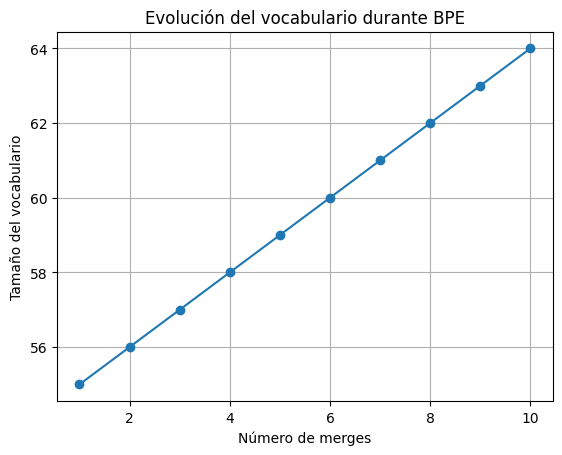

In [15]:
#VISUALIZACIÓN DE LA EVOLUCIÓN DEL VOCABULARIO
plt.plot(range(1, len(vocab_sizes)+1), vocab_sizes, marker='o')
plt.xlabel('Número de merges')
plt.ylabel('Tamaño del vocabulario')
plt.title('Evolución del vocabulario durante BPE')
plt.grid()
plt.show()

#### **EXPERIMENTACIÓN CON BPE**

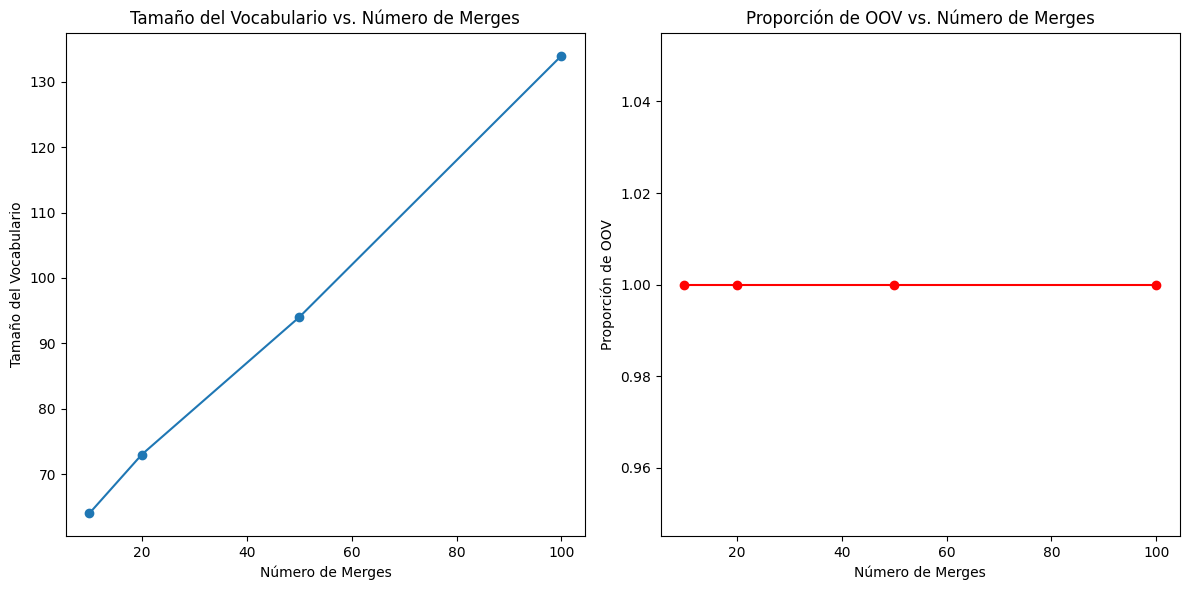

In [16]:
# Lista de diferentes valores para num_merges
num_merges_values = [10, 20, 50, 100]

# Variables para almacenar los resultados
vocab_sizes = []
oov_ratios = []

# Experimentamos con diferentes números de merges
for num_merges in num_merges_values:
    bpe_sentences = [sentence[:] for sentence in tokenized_sentences_by_char]  # Reiniciar las oraciones tokenizadas

    # Entrenamos el modelo BPE
    for merge_step in range(num_merges):
        pairs = obtener_pares(bpe_sentences)
        
        if not pairs:
            break  # Si ya no hay pares, terminamos
        
        # Seleccionamos el par más frecuente
        best_pair = pairs.most_common(1)[0][0]
        
        # Realizamos el merge
        bpe_sentences = merge_pairs(bpe_sentences, best_pair)
        
    # Guardamos el tamaño del vocabulario después de los merges
    vocab_actual = set()
    for sentence in bpe_sentences:
        vocab_actual.update(sentence)
    vocab_sizes.append(len(vocab_actual))
    
    # Evaluamos el número de OOV para algunas palabras
    test_words = ["unhappiness", "computational", "linguistics"]
    oov_count = sum([1 for word in test_words if word not in vocab_actual])
    oov_ratio = oov_count / len(test_words)
    oov_ratios.append(oov_ratio)

# Graficamos los resultados de BPE
plt.figure(figsize=(12, 6))

# Tamaño del vocabulario
plt.subplot(1, 2, 1)
plt.plot(num_merges_values, vocab_sizes, marker='o')
plt.title('Tamaño del Vocabulario vs. Número de Merges')
plt.xlabel('Número de Merges')
plt.ylabel('Tamaño del Vocabulario')

# Proporción de OOV
plt.subplot(1, 2, 2)
plt.plot(num_merges_values, oov_ratios, marker='o', color='r')
plt.title('Proporción de OOV vs. Número de Merges')
plt.xlabel('Número de Merges')
plt.ylabel('Proporción de OOV')

plt.tight_layout()
plt.show()

In [17]:
from src.bpe import BytePairEncoding

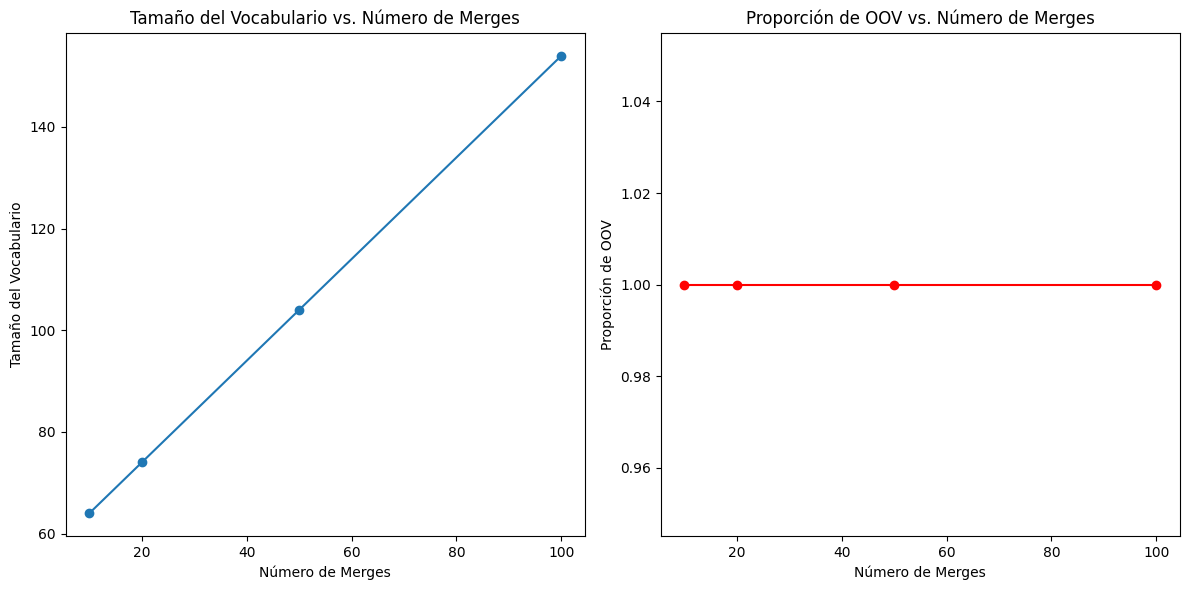

In [18]:
# Ajustamos el número de merges para experimentar con BPE
num_merges_values = [10, 20, 50, 100]  # Diferentes valores de num_merges

# Variables para almacenar los resultados
vocab_sizes = []
oov_ratios = []

# Experimentar con cada valor de num_merges
for num_merges in num_merges_values:
    # Re-iniciar el corpus original (bpe_sentences) para cada experimentación
    bpe_sentences = [sentence[:] for sentence in tokenized_sentences_by_char]
    
    # Entrenamos BPE con el número de merges seleccionado
    bpe_model = BytePairEncoding(num_merges)
    bpe_model.train(bpe_sentences)  # Entrenamiento del modelo BPE
    
    # Calculamos el tamaño del vocabulario final
    vocab_size = len(bpe_model.get_vocabulary())
    vocab_sizes.append(vocab_size)
    
    # Calculamos la proporción de OOV (Out-of-Vocabulary) para un ejemplo de palabra no vista
    test_words = ["unhappiness", "computational", "linguistics"]
    oov_count = sum([1 for word in test_words if word not in bpe_model.get_vocabulary()])
    oov_ratio = oov_count / len(test_words)
    oov_ratios.append(oov_ratio)

# Graficamos los resultados
plt.figure(figsize=(12, 6))

# Tamaño de vocabulario
plt.subplot(1, 2, 1)
plt.plot(num_merges_values, vocab_sizes, marker='o')
plt.title('Tamaño del Vocabulario vs. Número de Merges')
plt.xlabel('Número de Merges')
plt.ylabel('Tamaño del Vocabulario')

# Proporción de OOV
plt.subplot(1, 2, 2)
plt.plot(num_merges_values, oov_ratios, marker='o', color='r')
plt.title('Proporción de OOV vs. Número de Merges')
plt.xlabel('Número de Merges')
plt.ylabel('Proporción de OOV')

plt.tight_layout()
plt.show()

#### **Evaluación del modelo n-grama y cálculo de perplejidad**

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Función para calcular perplejidad
def calculate_perplexity(X_ngram):
    # Sumar los log de las probabilidades para cada token en X_ngram
    log_perplexity = -np.sum(np.log(X_ngram.sum(axis=1)))/X_ngram.shape[0]
    return np.exp(log_perplexity)

# Creamos un modelo n-grama simple (trabajando con caracteres)
def train_ngram_model(corpus, n=3):
    vectorizer = CountVectorizer(ngram_range=(n, n), tokenizer=lambda x: x.split())
    X = vectorizer.fit_transform(corpus)
    return vectorizer, X


In [25]:
# Preparamos los datos tokenizados por caracteres
corpus = [' '.join(sentence) for sentence in tokenized_sentences_by_char]

# Entrenamos el modelo n-grama con n=3 (trigramas)
vectorizer, X_ngram = train_ngram_model(corpus, n=3)

# Calculamos la perplejidad para el modelo n-grama
perplexity_ngram = calculate_perplexity(X_ngram)
print(f"Perplejidad del modelo n-grama: {perplexity_ngram}")

Perplejidad del modelo n-grama: 0.008396794069600123
